# CIFAR Code Along with CNN

## Perform standard imports

In [42]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sn # for heatmaps 
from sklearn.metrics import confusion_matrix

## Load the CIFAR-10 dataset

In [10]:
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='../Data', train=True, download=True, transform= transform)
test_data = datasets.CIFAR10(root='../Data', train=False, download=True, transform= transform)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [12]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

### Create loaders

In [13]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

### Define strings for labels

In [14]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

## View a batch of images

Label: [    3     2     0     4     9     5     1     2     4     8]
Class:    cat  bird plane  deer truck   dog   car  bird  deer  ship


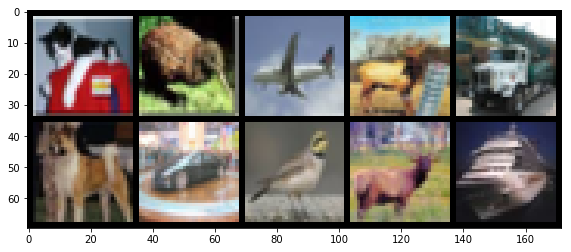

In [15]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Define the model

In [33]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)  
        self.conv2 = nn.Conv2d(32, 64, 3, 1)    
        self.fc1 = nn.Linear(6*6*64, 512)   
        self.fc2 = nn.Linear(512, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*64)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        return X

In [34]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

## Define loss function & optimizer

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train the model

In [36]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.67298770  accuracy:  35.540%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.03786969  accuracy:  41.605%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.93278599  accuracy:  45.483%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.05662477  accuracy:  48.290%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 1.50223494  accuracy:  50.658%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 0.77203482  accuracy:  62.600%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.25634360  accuracy:  63.610%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 0.75422192  accuracy:  64.143%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 0.99981499  accuracy:  64.680%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 0.71309310  accuracy:  65.196%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 0.75930059  accuracy:  70.980%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 0.90353221  accuracy:  70.710%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 0.96924132  accuracy:  70.967%
epoch:  2  b

## Save the model

In [37]:
torch.save(model.state_dict(), 'CIFAR10-CNN-Model.pt')

## Plot the loss and accuracy comparisons

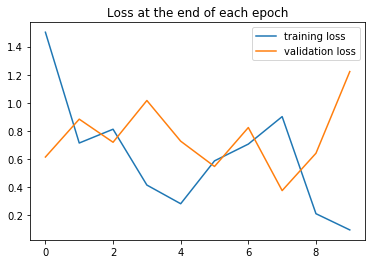

In [38]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

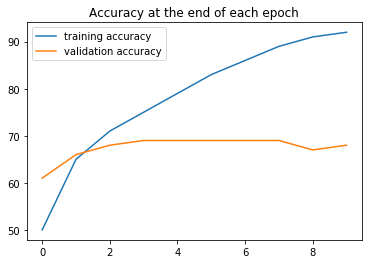

In [39]:
plt.plot([t/500 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Evaluate Test Data

In [40]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(6111), tensor(6679), tensor(6872), tensor(6911), tensor(6949), tensor(6919), tensor(6969), tensor(6953), tensor(6787), tensor(6866)]

Test accuracy: 68.660%


## Display the confusion matrix

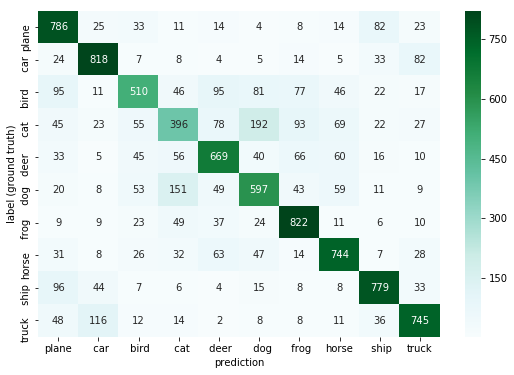

In [41]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();